# Описание набора данных и постановка задачи
В качестве набора данных был использован датасет с kaggle [Carvana Image Masking Challenge](https://www.kaggle.com/competitions/carvana-image-masking-challenge/data), а именно - чать данных, хранящаяся в архивах <b>train_hq.zip</b> (изображения высокого качества) и <b>train_masks.zip</b> (двоичные маски классов для сегментации). Файлы помещены в директории dataset/train/images и dataset/train/masks соответсвенно. </br> Задача - семантическая сегментация автомобилей на изображениях. 

<image src="dataset/train/images/0cdf5b5d0ce1_01.jpg" height=400 width=550> 
<image src="dataset/train/masks/0cdf5b5d0ce1_01_mask.gif" height=400 width=550>

# Конфигурация

Импортируем необходимые библиотеки (в файле requirements.txt находится информация о всех библиотеках и их версия в локальном окружении):

In [1]:
import torch
from torch.nn import Softmax2d, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from torchmetrics.classification import BinaryJaccardIndex

Введем онфигурационные параметры. Стоит обратить внимение размер batch'a и размер изображения. В дальнейшем обучение (с данными значениями) велось на локальной машине с использованием видеокарты NVIDIA 3080. Требовалось около 14 гб видеопамяти. В папке *saves* хранятся веса лучшей получившейся модели (можно использовать не обучая в секции "Оценка модели и результатов").

In [2]:
# Пути к данным
DATA_IMAGES = "dataset/train/images/"
DATA_MASKS = "dataset/train/masks/"

# Рабочий размер для изображений
IMG_HEIGHT, IMG_WIDTH = 400, 400

# Параметры обучения
BATCH_SZ = 20
EPOCHS = 30

# Порог вероятности предсказания маски
MASK_THRESHOLD = 0.5

Выберем cuda-устройство для ускорения обучения:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

# Загрузка и обработка данных

В целом, данные предоставляемые датасетом не нудаются в сложной обработке. Необходимо лишь реализовать загрузку изображений и масков формате, удобном для дальнейшего использования. А именно, конвертировать изображение в rgb, представить маски в виде двухканальных изображений (классы: авто и фон), уменьшить разрешение. Класс *SegmentDataset*, созданный в файле *data.py* служит для управления данными и представлением их в нужном виде (код снабжен комментариями).

Импортируем класс:

In [5]:
from data import SegmentDataset

Найдем все пути к изображениям и маскам и загрузим их:

In [6]:
all_imgs, all_masks = sorted(glob.glob(DATA_IMAGES+"*")), sorted(glob.glob(DATA_MASKS+"*"))
train_data, val_data = train_test_split(np.array([all_imgs,all_masks]).T,test_size=0.2,random_state=88)

Необходимые трансформации (сжатие и превращение в тензор для дальнейшей работы):

In [7]:
trans = transforms.Compose([
 	transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
	transforms.ToTensor()])

In [8]:
train_dataset = SegmentDataset(train_data[:,0],train_data[:,1],transforms=trans)
val_dataset = SegmentDataset(val_data[:,0],val_data[:,1],transforms=trans)

Визуализируем данные (из тестового датасета):

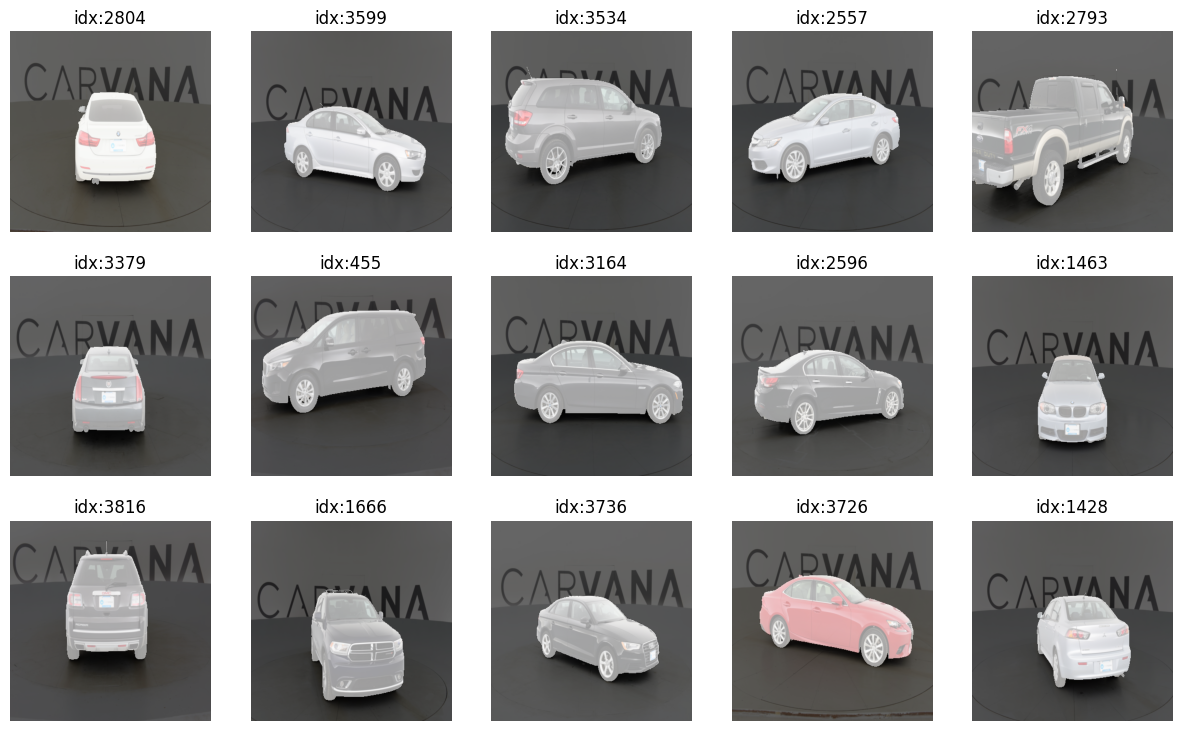

In [9]:
plt.rcParams["figure.figsize"] = (15,9)
fig, ax =plt.subplots(3,5)

for i_ in range(3):
	for j_ in range(5):
		ran_index = random.randint(0,len(train_dataset))
		img, mask = train_dataset.__getitem__(ran_index)
		mask = mask[1]
		
		ax[i_,j_].axis("off")
		ax[i_,j_].set_title(f"idx:{ran_index}")

		ax[i_,j_].imshow(img.permute((1,2,0)).numpy())
		ax[i_,j_].imshow(mask.numpy(),cmap="gray",alpha=0.6)

Создадим объекты *DataLoader* для удобного доступа к данным во время обучения:

In [10]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SZ, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SZ, pin_memory=True)

# Создание модели

Для решения поставленной задачи было решено использовать популярную модель для сегментации изображений - UNet. Реализованная модель была создана на основе оффициальной статьи [UNet](https://arxiv.org/abs/1505.04597). Код реализации находится в файле *UNet.py*.

Основная идея, обеспечивающая высокую точность модели для задач сегментации - использование Encoder-Decoder подхода с прямыми связями между уровнями слоев. Данная нейронная сеть является полностью сверточной, что позволяет ей работать с изображениями произвольного размера (однако в данномм случае стандартизируем этот параметр для упрощения обучения). На выходе мы получим изображение, содержащее 2 канала (т.к. в данном случае у нас 2 класса). Применив к ним Softmax получим верятности принадлежности к классам. В конечном итоге необходимо интерполировать выхлдное изображение для возвращения к изначальной размерности (на выходе она немного отличается).

In [11]:
from UNet import UNet

In [12]:
unet_model = UNet(num_classes=2).to(device) # Создадим модель
lossFunc = CrossEntropyLoss() # Объявим функцию потерь - стандарная для классификации/сегментации
opt = Adam(unet_model.parameters(), lr=0.001) # Оптимизатор
train_steps = len(train_dataset) // BATCH_SZ
val_steps = len(val_dataset) // BATCH_SZ

Запустим стандартный цикл обучения попутно собирая статистику о функции потерь (каждые 5 эпох созраняем веса в папку *saves*):

In [13]:
stats = {"loss train": [], "loss val": []}
start_time = time.time()
prev_time = time.time()
for epoch in range(EPOCHS):
	print(f"[INFO] EPOCH: {epoch + 1}/{EPOCHS}")
	unet_model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	print("Training...")
	for (i, (x, y)) in enumerate(train_dataloader):
		(x, y) = (x.to(device), y.to(device))
		pred = unet_model(x)
		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()
		totalTrainLoss += loss
	print("Validation...")
	with torch.no_grad():
		unet_model.eval()
		for (x, y) in val_dataloader:
			(x, y) = (x.to(device), y.to(device))
			pred = unet_model(x)
			totalValLoss += lossFunc(pred, y)

	avgTrainLoss = totalTrainLoss / train_steps
	avgValLoss = totalValLoss / val_steps
	stats["loss train"].append(avgTrainLoss.cpu().detach().numpy())
	stats["loss val"].append(avgValLoss.cpu().detach().numpy())
	
	
	
	if epoch > 0 and (epoch+1) % 5 == 0:
		print("Saving...")
		torch.save(unet_model,f"saves/weights_{epoch+1}_epoch.pt")
	now_time = time.time()
	print(f"Train average loss: {avgTrainLoss}, Validation average loss: {avgValLoss}")
	print(f"Time per epoch: {int((now_time - prev_time)//60)}m {int((now_time - prev_time) % 60)}s, Total time: {int((now_time-start_time)//3600)}h {int(((now_time-start_time)%3600)//60 + 1)}m")
	print()
	prev_time = now_time

[INFO] EPOCH: 1/30
Training...
Validation...
Train average loss: 0.5351714491844177, Validation average loss: 0.5091358423233032
Time per epoch: 2m 46s, Total time: 0h 3m

[INFO] EPOCH: 2/30
Training...
Validation...
Train average loss: 0.3546825051307678, Validation average loss: 0.2642168700695038
Time per epoch: 2m 46s, Total time: 0h 6m

[INFO] EPOCH: 3/30
Training...
Validation...
Train average loss: 0.24122770130634308, Validation average loss: 0.21129025518894196
Time per epoch: 2m 44s, Total time: 0h 9m

[INFO] EPOCH: 4/30
Training...
Validation...
Train average loss: 0.17426107823848724, Validation average loss: 0.1633663773536682
Time per epoch: 2m 44s, Total time: 0h 12m

[INFO] EPOCH: 5/30
Training...
Validation...
Saving...
Train average loss: 0.14412948489189148, Validation average loss: 0.1387084424495697
Time per epoch: 2m 43s, Total time: 0h 14m

[INFO] EPOCH: 6/30
Training...
Validation...
Train average loss: 0.12940570712089539, Validation average loss: 0.12689125537

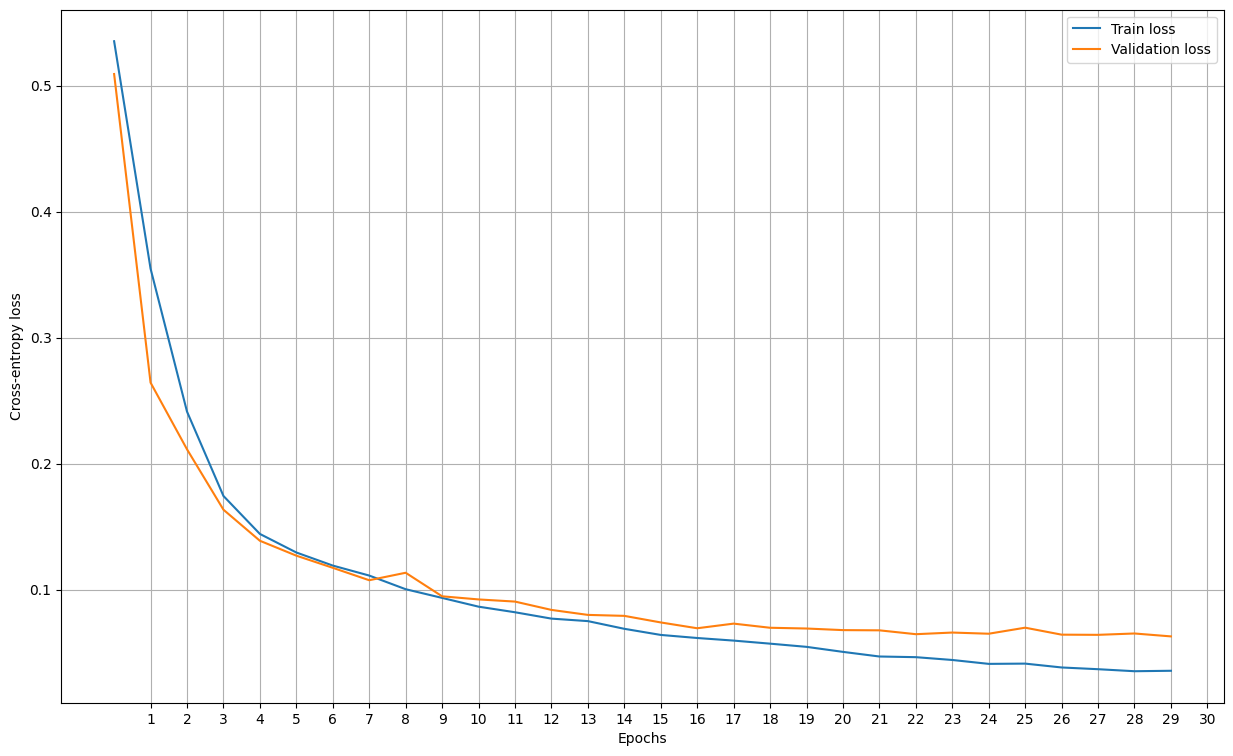

In [14]:
plt.plot(range(len(stats["loss train"])),stats["loss train"],label="Train loss")
plt.plot(range(len(stats["loss val"])),stats["loss val"],label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.xticks(list(range(1,EPOCHS+1)))
plt.grid(True)
plt.legend()

# Оценка модели и результатов

Можем загрузить обученную ранее модель (лучший результат сохранен в папке *saves*):

In [15]:
# unet_model = torch.load("saves/best.pt").to(device)

Для оценки качества модели используем метрику [IOU](https://en.wikipedia.org/wiki/Jaccard_index) (Intersection Over Union). Ее значения около 0.75 считаются неплохим результатом для задач сегментации.

In [16]:
IOU_metrics = BinaryJaccardIndex()

Оценку проведем на валидационном датасете (он не был использован для подбора гиперпараметров, так что это допустимо), т.к. для тестовых данных отсутвуют маски (они нужен для участия в соревновании kaggle).

In [17]:
import numpy as np

In [18]:
metrics = []
with torch.no_grad():
	unet_model.eval()
	for i in range(len(val_dataset)):
		img, mask = val_dataset.__getitem__(i)
		pred = unet_model(img.view(1,3,IMG_HEIGHT,IMG_WIDTH).to(device)).detach().cpu()
		pred_ = Softmax2d()(pred).view((2,IMG_HEIGHT,IMG_WIDTH))[1,:,:] > MASK_THRESHOLD
		mask = mask[1]
		metrics.append(IOU_metrics(mask,pred_).item())
print(f"Среднее значение метрики на валидационном датасете: {np.mean(metrics)}")

Среднее значение метрики на валидационном датасете: 0.8966525437087113


Визуализируем работу получившейся модели:

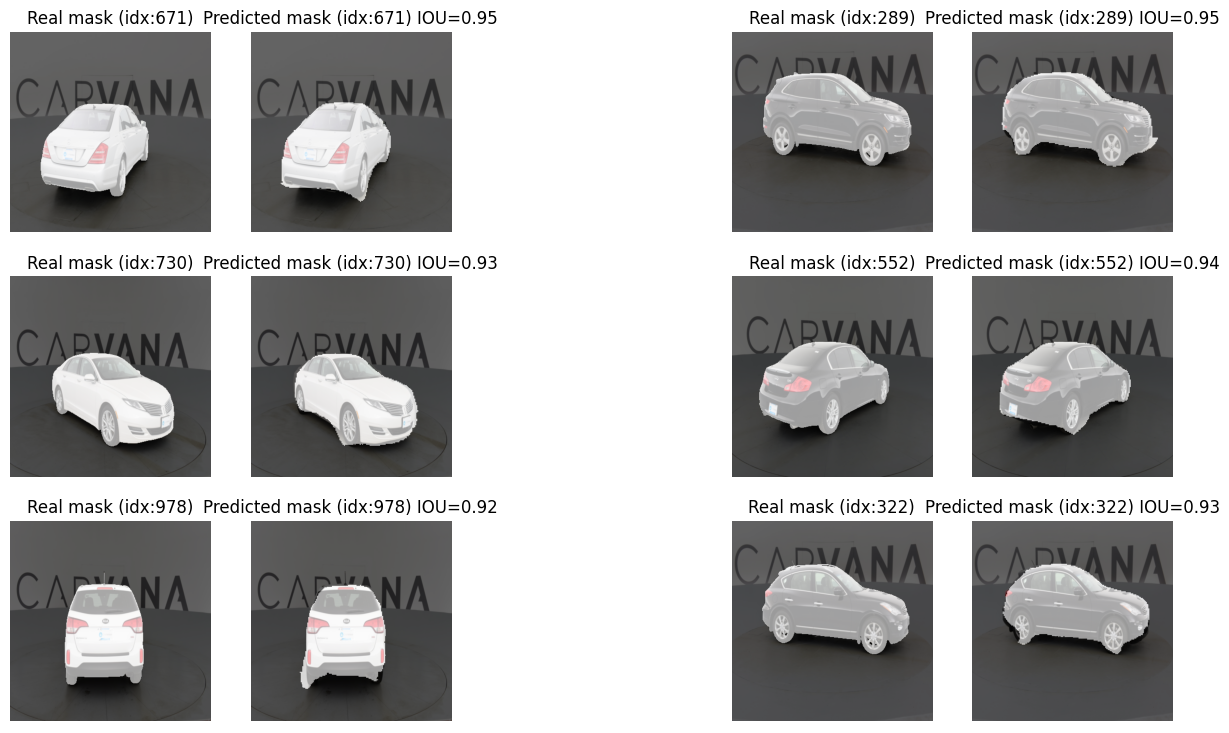

In [19]:
unet_model.eval()
plt.rcParams["figure.figsize"] = (15,9)
fig, ax =plt.subplots(3,5)

for i_ in range(3):
	ax[i_,2].axis("off")
	for j_ in [0,3]:
		ran_index = random.randint(0,len(val_dataset))
		img, mask = val_dataset.__getitem__(ran_index)
		pred = unet_model(img.reshape(1,3,IMG_HEIGHT,IMG_WIDTH).to(device)).detach().cpu()
		pred_ = Softmax2d()(pred).view((2,IMG_HEIGHT,IMG_WIDTH))[1,:,:] > MASK_THRESHOLD
		mask = mask[1]
		met =IOU_metrics(mask,pred_)
		
		ax[i_,j_].axis("off")
		ax[i_,j_+1].axis("off")

		ax[i_,j_].set_title(f"Real mask (idx:{ran_index})")
		ax[i_,j_+1].set_title(f"Predicted mask (idx:{ran_index}) IOU={round(met.item(),2)}")

		ax[i_,j_].imshow(img.permute((1,2,0)).numpy())
		ax[i_,j_].imshow(mask.numpy(),cmap="gray",alpha=0.6)

		ax[i_,j_+1].imshow(img.permute((1,2,0)).numpy())
		ax[i_,j_+1].imshow(pred_.numpy(),cmap="gray",alpha=0.6)

		

# Итоги
После обучения модели, она демонстрирует приемлемую точность на валидационных данных. Архитектура UNet оказалась довольно эффективной даже в столь стандартной реализации. Стоит, однако, отметить, что для обучения требовались значительные вычислительные ресурсы.